In [557]:
import pandas as pd # for dataframes
import numpy as np
import matplotlib.pyplot as plt # for simple plots
from sklearn.preprocessing import StandardScaler
import phik
from phik.report import plot_correlation_matrix
from phik import report
import seaborn as sns # for slightly more complicated plots
import numpy as np # for numerical computing and linear algebra data structur
from numba import jit # for JIT compilation facilties for improved efficiency

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score, recall_score, f1_score

#### Data Ingestion

DATA DESCRIPTION:<br>
Input features:<br>
Objective: factual information;<br>
Examination: results of medical examination;<br>
Subjective: information given by the patient.<br>

Features:<br>
Age | Objective Feature | age | int (days)<br>
Height | Objective Feature | height | int (cm) |<br>
Weight | Objective Feature | weight | float (kg) |<br>
Gender | Objective Feature | gender | categorical code | 1 - women, 2 - men |<br>
Systolic blood pressure | Examination Feature | ap_hi | int |<br>
Diastolic blood pressure | Examination Feature | ap_lo | int |<br>
Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |<br>
Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |<br>
Smoking | Subjective Feature | smoke | binary | 1-Yes, 0-No<br>
Alcohol intake | Subjective Feature | alco | binary | 1-Yes, 0-No<br>
Physical activity | Subjective Feature | active | binary | 1-Yes, 0-No<br>
Presence or absence of cardiovascular disease | Target Variable | cardio | binary | 1-Yes, 0-No” <br>


In [558]:
#Reading in the data and storing it into a pandas dataframe
df = pd.read_csv('cardio_train 3.csv',sep=';') 

#### Data Pre-Processing

In [559]:
#display first 20 rows
df.head(20)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


#### Checking for duplicate ids in the dataset

In [560]:
df['id'].value_counts() 
#no duplicates found hence keep all rows

0        1
66623    1
66631    1
66630    1
66628    1
        ..
33338    1
33339    1
33340    1
33341    1
99999    1
Name: id, Length: 70000, dtype: int64

Converting age from number of days to year

In [561]:
df['age'] = (df['age'] / 365.25).astype(int)
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0


#### Data Observation

In [562]:
df.info()
#The data is in an appropriate format and contains all its values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


#### Data imputation to preserve statistical power, avoid bias as much as possible.

In [563]:
def produce_missing_report(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({
                                     'percent_missing': percent_missing})
    return missing_value_df

produce_missing_report(df) #Confirmed no data missing from the rows

,percent_missing
id,0.0
age,0.0
gender,0.0
height,0.0
weight,0.0
ap_hi,0.0
ap_lo,0.0
cholesterol,0.0
gluc,0.0
smoke,0.0


#### Data Standardization to ensure that all features have a similar scale and variance.

In [564]:
def standardize_col(col):
    scaler = StandardScaler()
    std_col = scaler.fit_transform(col.values.reshape(-1, 1))
    return std_col

standardize_col(df['age'])
standardize_col(df['height'])
standardize_col(df['weight'])
standardize_col(df['ap_hi'])
standardize_col(df['ap_lo'])
df.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0


#### Outlier Detection analysis on the age, height, weight, ap_hi, and ap_lo columns, since they are continuous numerical variables that may have outliers.

Performing outlier detection on the age column

In [565]:
df['age'].describe()

count    70000.000000
mean        52.803257
std          6.762462
min         29.000000
25%         48.000000
50%         53.000000
75%         58.000000
max         64.000000
Name: age, dtype: float64

In [566]:
Q1 = df['age'].quantile(0.25)
print("Q1 ", Q1)
Q3 = df['age'].quantile(0.75)
print("Q3 ", Q3)
IQR = Q3 - Q1
print("IQR", IQR)

Q1  48.0
Q3  58.0
IQR 10.0


In [567]:
upper_bound = Q3 + 1.5 * IQR
print("upper ", upper_bound)
lower_bound = Q1 - 1.5 * IQR
print("lower ", lower_bound)

upper  73.0
lower  33.0


In [568]:
df_without_outliers = df[(df['age'] < upper_bound) & (df['age'] > lower_bound)]
df_without_outliers

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,61,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


{'whiskers': [<matplotlib.lines.Line2D at 0x14f34b070>,
 'caps': [<matplotlib.lines.Line2D at 0x14f349e40>,
 'boxes': [<matplotlib.lines.Line2D at 0x14f348550>],
 'medians': [<matplotlib.lines.Line2D at 0x14f349b40>],
 'fliers': [<matplotlib.lines.Line2D at 0x149452980>],
 'means': []}

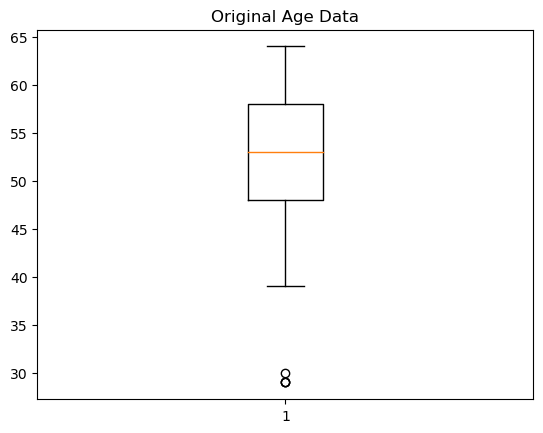

In [569]:
fig1, ax1 = plt.subplots()
ax1.set_title('Original Age Data')
ax1.boxplot(df['age'])

{'whiskers': [<matplotlib.lines.Line2D at 0x14f3b33a0>,
 'caps': [<matplotlib.lines.Line2D at 0x14f3b38e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x14f3b3100>],
 'medians': [<matplotlib.lines.Line2D at 0x14f3b3e20>],
 'fliers': [<matplotlib.lines.Line2D at 0x14f3e4100>],
 'means': []}

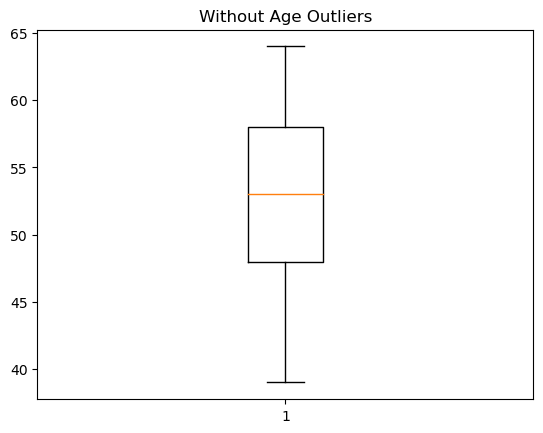

In [570]:
fig1, ax1 = plt.subplots()
ax1.set_title('Without Age Outliers')
ax1.boxplot(df_without_outliers['age'])

In [571]:
df_without_outliers = df[(df['age'] > lower_bound) & (df['age'] < upper_bound)].reset_index(drop=True)
df = df_without_outliers
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69991,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69992,99995,61,1,158,126.0,140,90,2,2,0,0,1,1
69993,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69994,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


Performing outlier detection on the height column

In [572]:
df['height'].describe() # uncertain of if this is needed, people have varied height doesnt mean it contributes to CVD. however the column continuous. do correlation matrix to see the relevance

count    69996.000000
mean       164.359063
std          8.210122
min         55.000000
25%        159.000000
50%        165.000000
75%        170.000000
max        250.000000
Name: height, dtype: float64

In [573]:
Q1 = df['height'].quantile(0.25)
print("Q1 ", Q1)
Q3 = df['height'].quantile(0.75)
print("Q3 ", Q3)
IQR = Q3 - Q1
print("IQR", IQR)

Q1  159.0
Q3  170.0
IQR 11.0


In [574]:
upper_bound = Q3 + 1.5 * IQR
print("upper ", upper_bound)
lower_bound = Q1 - 1.5 * IQR
print("lower ", lower_bound)

upper  186.5
lower  142.5


In [575]:
df_without_outliers = df[(df['height'] < upper_bound) & (df['height'] > lower_bound)]
df_without_outliers

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69991,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69992,99995,61,1,158,126.0,140,90,2,2,0,0,1,1
69993,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69994,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


{'whiskers': [<matplotlib.lines.Line2D at 0x14f2c8cd0>,
 'caps': [<matplotlib.lines.Line2D at 0x14f2c9210>,
 'boxes': [<matplotlib.lines.Line2D at 0x14f2fbc40>],
 'medians': [<matplotlib.lines.Line2D at 0x14f2c9750>],
 'fliers': [<matplotlib.lines.Line2D at 0x14f2c99f0>],
 'means': []}

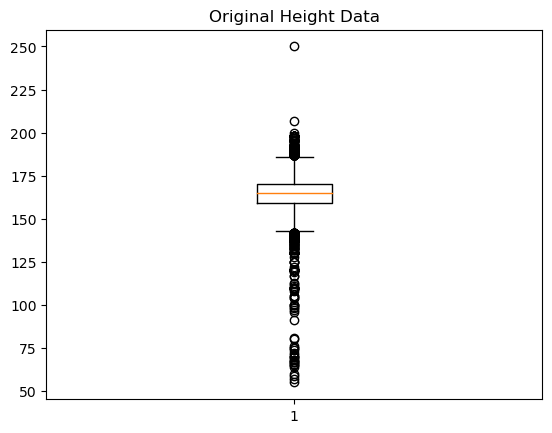

In [576]:
fig1, ax1 = plt.subplots()
ax1.set_title('Original Height Data')
ax1.boxplot(df['height'])

{'whiskers': [<matplotlib.lines.Line2D at 0x14f2738b0>,
 'caps': [<matplotlib.lines.Line2D at 0x14f273df0>,
 'boxes': [<matplotlib.lines.Line2D at 0x14f273610>],
 'medians': [<matplotlib.lines.Line2D at 0x14f240370>],
 'fliers': [<matplotlib.lines.Line2D at 0x14f240610>],
 'means': []}

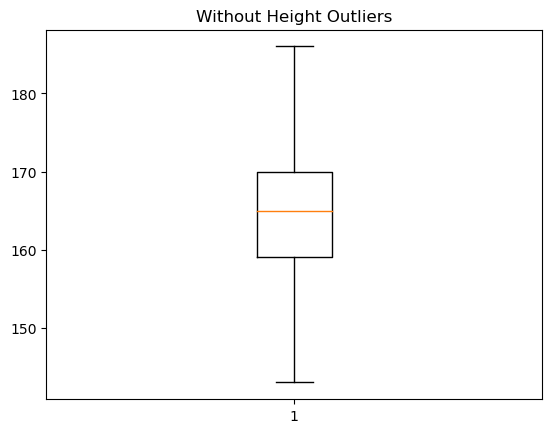

In [577]:
fig1, ax1 = plt.subplots()
ax1.set_title('Without Height Outliers')
ax1.boxplot(df_without_outliers['height'])

In [578]:
df_without_outliers = df[(df['height'] > lower_bound) & (df['height'] < upper_bound)].reset_index(drop=True)
df = df_without_outliers
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69472,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69473,99995,61,1,158,126.0,140,90,2,2,0,0,1,1
69474,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69475,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


Performing outlier detection on the weight column

In [579]:
df['weight'].describe()

count    69477.000000
mean        74.152953
std         14.287850
min         10.000000
25%         65.000000
50%         72.000000
75%         82.000000
max        200.000000
Name: weight, dtype: float64

In [580]:
Q1 = df['weight'].quantile(0.25)
print("Q1 ", Q1)
Q3 = df['weight'].quantile(0.75)
print("Q3 ", Q3)
IQR = Q3 - Q1
print("IQR", IQR)

Q1  65.0
Q3  82.0
IQR 17.0


In [581]:
upper_bound = Q3 + 1.5 * IQR
print("upper ", upper_bound)
lower_bound = Q1 - 1.5 * IQR
print("lower ", lower_bound)

upper  107.5
lower  39.5


In [582]:
df_without_outliers = df[(df['weight'] < upper_bound) & (df['weight'] > lower_bound)]
df_without_outliers

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69471,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
69472,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69474,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69475,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


{'whiskers': [<matplotlib.lines.Line2D at 0x14f4107c0>,
 'caps': [<matplotlib.lines.Line2D at 0x14f410d00>,
 'boxes': [<matplotlib.lines.Line2D at 0x14f4104f0>],
 'medians': [<matplotlib.lines.Line2D at 0x14f411240>],
 'fliers': [<matplotlib.lines.Line2D at 0x14f4114e0>],
 'means': []}

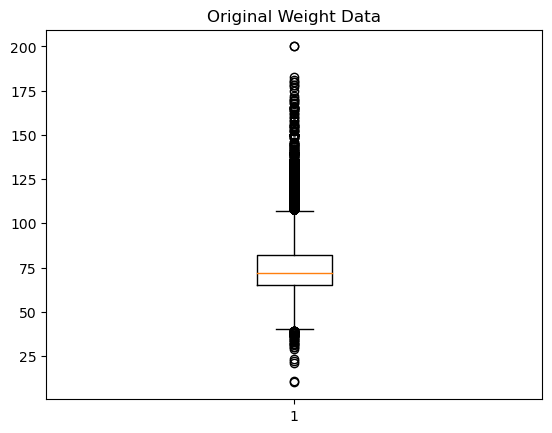

In [583]:
fig1, ax1 = plt.subplots()
ax1.set_title('Original Weight Data')
ax1.boxplot(df['weight'])

{'whiskers': [<matplotlib.lines.Line2D at 0x14f462fb0>,
 'caps': [<matplotlib.lines.Line2D at 0x14f4634f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x14f462d40>],
 'medians': [<matplotlib.lines.Line2D at 0x14f463a30>],
 'fliers': [<matplotlib.lines.Line2D at 0x14f463cd0>],
 'means': []}

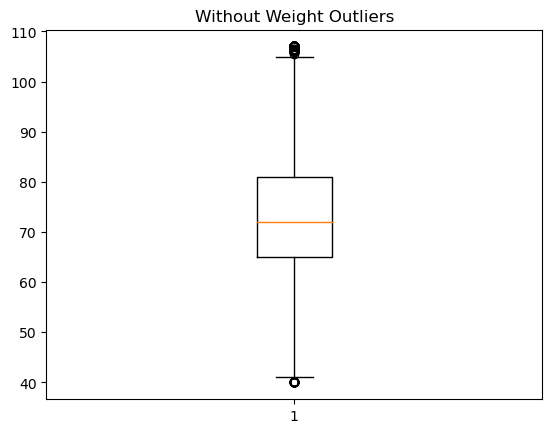

In [584]:
fig1, ax1 = plt.subplots()
ax1.set_title('Without Weight Outliers')
ax1.boxplot(df_without_outliers['weight'])

In [585]:
df_without_outliers = df[(df['weight'] > lower_bound) & (df['weight'] < upper_bound)].reset_index(drop=True)
df = df_without_outliers
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67714,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
67715,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
67716,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
67717,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


Performing outlier detection on the ap_hi column

In [586]:
df['ap_hi'].describe()

count    67719.000000
mean       128.585951
std        156.528328
min       -150.000000
25%        120.000000
50%        120.000000
75%        140.000000
max      16020.000000
Name: ap_hi, dtype: float64

In [587]:
Q1 = df['ap_hi'].quantile(0.25)
print("Q1 ", Q1)
Q3 = df['ap_hi'].quantile(0.75)
print("Q3 ", Q3)
IQR = Q3 - Q1
print("IQR", IQR)

Q1  120.0
Q3  140.0
IQR 20.0


In [588]:
upper_bound = Q3 + 1.5 * IQR
print("upper ", upper_bound)
lower_bound = Q1 - 1.5 * IQR
print("lower ", lower_bound)

upper  170.0
lower  90.0


In [589]:
df_without_outliers = df[(df['ap_hi'] < upper_bound) & (df['ap_hi'] > lower_bound)]
df_without_outliers

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67713,99991,53,1,172,70.0,130,90,1,1,0,0,1,1
67714,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
67715,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
67717,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


{'whiskers': [<matplotlib.lines.Line2D at 0x14f413a30>,
 'caps': [<matplotlib.lines.Line2D at 0x14f4ddba0>,
 'boxes': [<matplotlib.lines.Line2D at 0x14f498700>],
 'medians': [<matplotlib.lines.Line2D at 0x14f4de0e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x14f4de380>],
 'means': []}

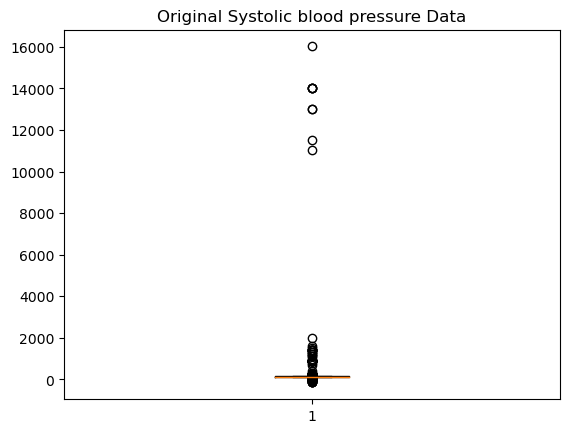

In [590]:
fig1, ax1 = plt.subplots()
ax1.set_title('Original Systolic blood pressure Data')
ax1.boxplot(df['ap_hi'])

{'whiskers': [<matplotlib.lines.Line2D at 0x14f568790>,
 'caps': [<matplotlib.lines.Line2D at 0x14f568cd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x14f5684f0>],
 'medians': [<matplotlib.lines.Line2D at 0x14f569210>],
 'fliers': [<matplotlib.lines.Line2D at 0x14f5694b0>],
 'means': []}

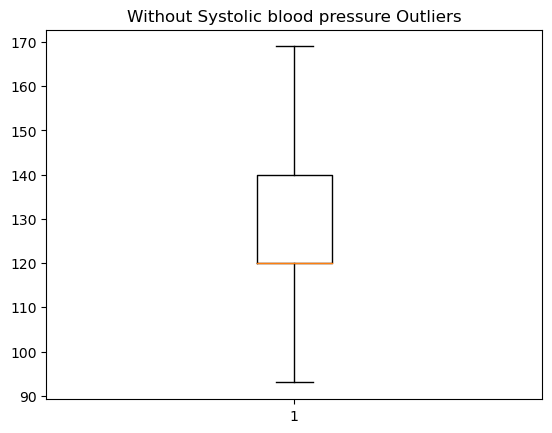

In [591]:
fig1, ax1 = plt.subplots()
ax1.set_title('Without Systolic blood pressure Outliers')
ax1.boxplot(df_without_outliers['ap_hi'])

In [592]:
df_without_outliers = df[(df['ap_hi'] > lower_bound) & (df['ap_hi'] < upper_bound)].reset_index(drop=True)
df = df_without_outliers
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64798,99991,53,1,172,70.0,130,90,1,1,0,0,1,1
64799,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
64800,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
64801,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


Performing outlier detection on the ap_lo column

In [593]:
df['ap_lo'].describe()

count    64803.000000
mean        93.685107
std        181.503375
min          0.000000
25%         80.000000
50%         80.000000
75%         90.000000
max      10000.000000
Name: ap_lo, dtype: float64

In [594]:
Q1 = df['ap_lo'].quantile(0.25)
print("Q1 ", Q1)
Q3 = df['ap_lo'].quantile(0.75)
print("Q3 ", Q3)
IQR = Q3 - Q1
print("IQR", IQR)

Q1  80.0
Q3  90.0
IQR 10.0


In [595]:
upper_bound = Q3 + 1.5 * IQR
print("upper ", upper_bound)
lower_bound = Q1 - 1.5 * IQR
print("lower ", lower_bound)

upper  105.0
lower  65.0


In [596]:
df_without_outliers = df[(df['ap_lo'] < upper_bound) & (df['ap_lo'] > lower_bound)]
df_without_outliers

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
5,8,59,1,151,67.0,120,80,2,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64798,99991,53,1,172,70.0,130,90,1,1,0,0,1,1
64799,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
64800,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
64801,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


{'whiskers': [<matplotlib.lines.Line2D at 0x14f5bb2b0>,
 'caps': [<matplotlib.lines.Line2D at 0x14f5bb7f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x14f5b9330>],
 'medians': [<matplotlib.lines.Line2D at 0x14f5bbd30>],
 'fliers': [<matplotlib.lines.Line2D at 0x14f5bbfd0>],
 'means': []}

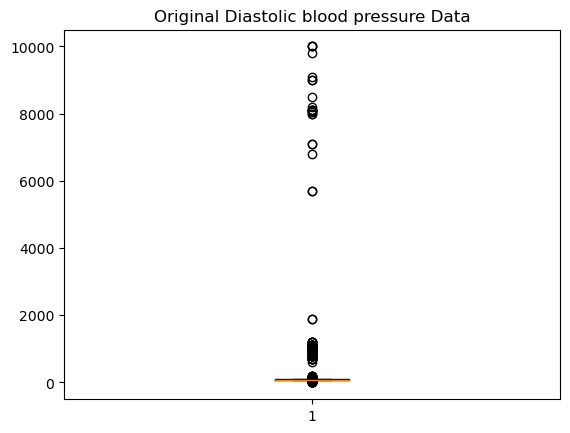

In [597]:
fig1, ax1 = plt.subplots()
ax1.set_title('Original Diastolic blood pressure Data')
ax1.boxplot(df['ap_lo'])

{'whiskers': [<matplotlib.lines.Line2D at 0x14f644e20>,
 'caps': [<matplotlib.lines.Line2D at 0x14f645360>,
 'boxes': [<matplotlib.lines.Line2D at 0x14f514730>],
 'medians': [<matplotlib.lines.Line2D at 0x14f645780>],
 'fliers': [<matplotlib.lines.Line2D at 0x14f645a20>],
 'means': []}

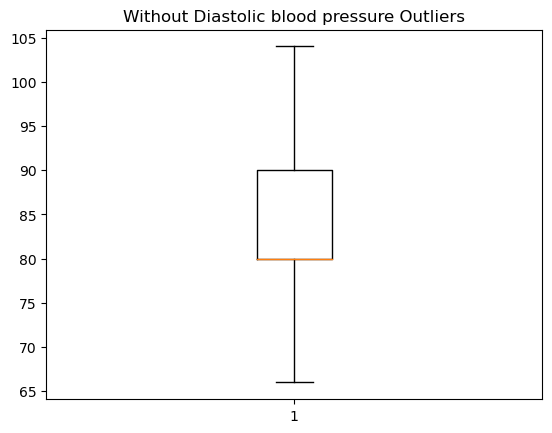

In [598]:
fig1, ax1 = plt.subplots()
ax1.set_title('Without Diastolic blood pressure Outliers')
ax1.boxplot(df_without_outliers['ap_lo'])

In [599]:
df_without_outliers = df[(df['ap_lo'] > lower_bound) & (df['ap_lo'] < upper_bound)].reset_index(drop=True)
df = df_without_outliers
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,8,59,1,151,67.0,120,80,2,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61766,99991,53,1,172,70.0,130,90,1,1,0,0,1,1
61767,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
61768,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
61769,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


## EDA

Non-Modifiable Cause:

Old Age
Heridity
Gender Factor such as Male

Modifiable Cause: 
Alcohol
Smoking
Physical activity


## Univariate 


In [600]:
df.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

In [601]:
# to understand variables look at their datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61771 entries, 0 to 61770
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           61771 non-null  int64  
 1   age          61771 non-null  int64  
 2   gender       61771 non-null  int64  
 3   height       61771 non-null  int64  
 4   weight       61771 non-null  float64
 5   ap_hi        61771 non-null  int64  
 6   ap_lo        61771 non-null  int64  
 7   cholesterol  61771 non-null  int64  
 8   gluc         61771 non-null  int64  
 9   smoke        61771 non-null  int64  
 10  alco         61771 non-null  int64  
 11  active       61771 non-null  int64  
 12  cardio       61771 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.1 MB


<AxesSubplot: xlabel='years', ylabel='count'>

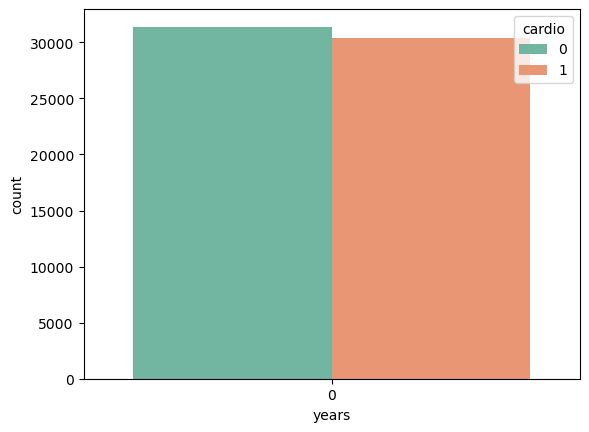

In [602]:
df['years']=(df['age']/365).round().astype(int)
#df['years']
sns.countplot(x='years', hue='cardio', data = df, palette="Set2")
#This plot has shown that CVD is more prevelant in patients who are older

In [603]:
df.describe()
#displays statistics such as min, max, mean, std

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,years
count,61771.000000,61771.000000,61771.000000,61771.000000,61771.000000,61771.000000,61771.000000,61771.000000,61771.000000,61771.000000,61771.000000,61771.000000,61771.000000,61771.0
mean,49958.487041,52.863123,1.348853,164.421622,73.159013,126.182189,81.651163,1.355863,1.220103,0.086432,0.052015,0.804309,0.491865,0.0
std,28868.135268,6.734729,0.476611,7.526360,12.247023,13.692640,7.566325,0.674082,0.567387,0.281003,0.222058,0.396735,0.499938,0.0
min,0.000000,39.000000,1.000000,143.000000,40.000000,95.000000,66.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,24888.500000,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0
50%,50013.000000,53.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0
75%,74893.500000,58.000000,2.000000,170.000000,81.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.0
max,99999.000000,64.000000,2.000000,186.000000,107.000000,169.000000,104.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.0


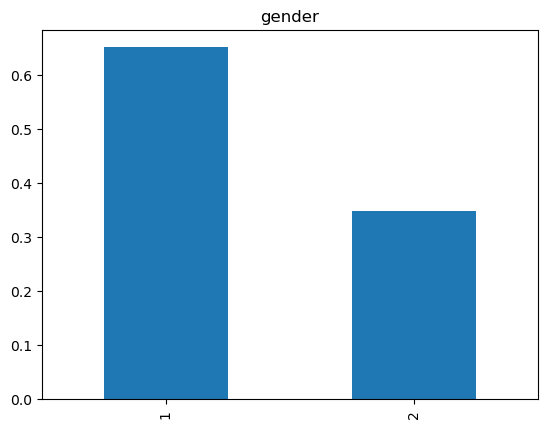

In [604]:
plt.figure(1) 
df['gender'].value_counts(normalize=True).plot.bar(title= 'gender') 
plt.show()

<AxesSubplot: xlabel='variable', ylabel='count'>

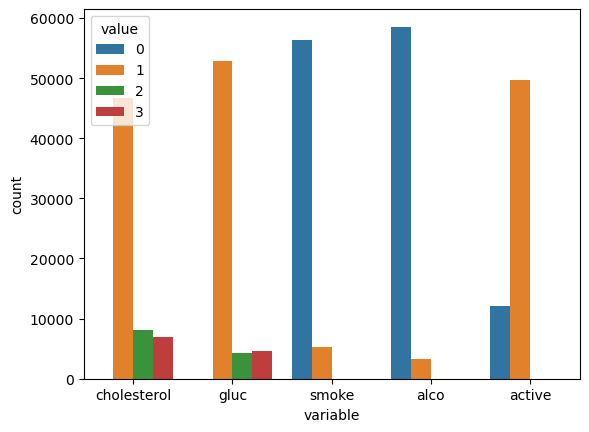

In [605]:
df_categorical = df.loc[:,['cholesterol','gluc', 'smoke', 'alco', 'active']]
sns.countplot(x="variable", hue="value",data= pd.melt(df_categorical))
# this shows the socioeconomic factors that affect patients (some attributes that may lead to cvd)

<AxesSubplot: ylabel='Frequency'>

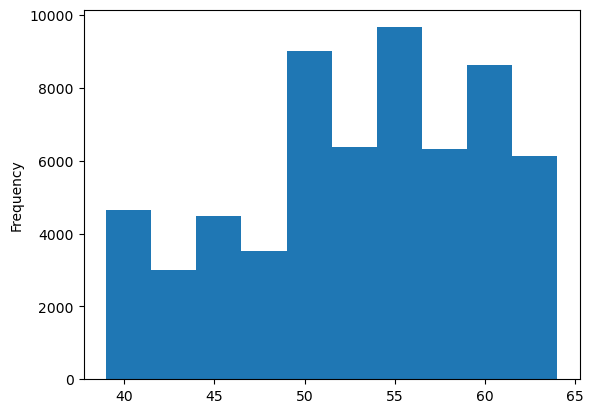

In [606]:
df['age'].plot(kind='hist')
#distribution of age in terms of days in this dataset

<AxesSubplot: ylabel='Frequency'>

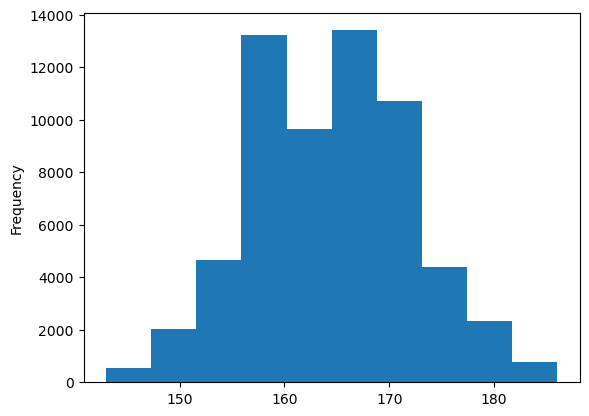

In [607]:
df['height'].plot(kind='hist')
# patients in this dataset were avg 150-175 in height

<AxesSubplot: ylabel='Frequency'>

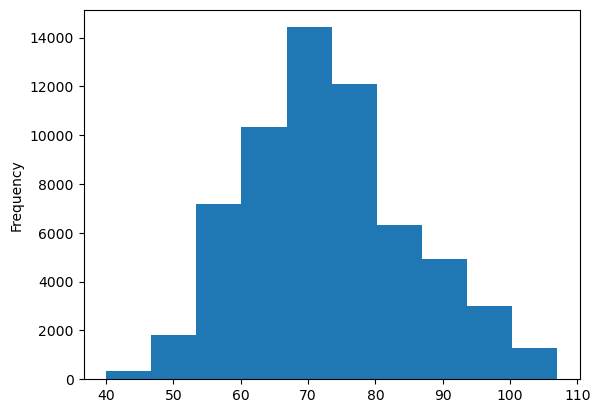

In [608]:
df['weight'].plot(kind='hist')
#patients in this dataset (were mainly 50-80 in weight)

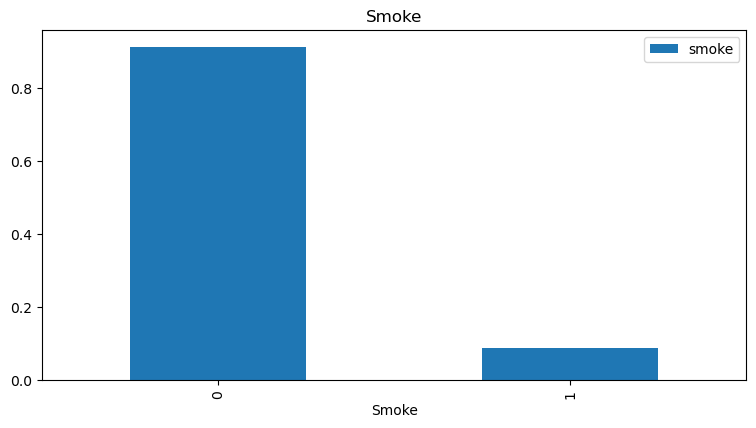

In [609]:
plt.figure(1) 

plt.subplot(221)
df['smoke'].value_counts(normalize=True).plot.bar(figsize=(20,10), title= 'Smoke') 
plt.xlabel('Smoke')
# plt.title ('Distribution of Smoke')
plt.legend()
plt.show()

# Patients who smoke are at higher risk of getting CVD

<AxesSubplot: ylabel='alco'>

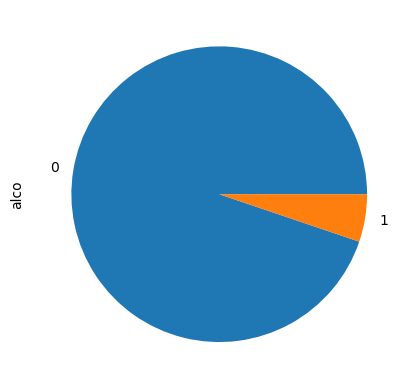

In [610]:
df["alco"].value_counts().plot(kind='pie')
# however, most of the patients in the dataset are seen to be non alcoholics  

/Users/tamikaramkissoon/opt/anaconda3/envs/kris_env/lib/python3.10/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/tamikaramkissoon/opt/anaconda3/envs/kris_env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


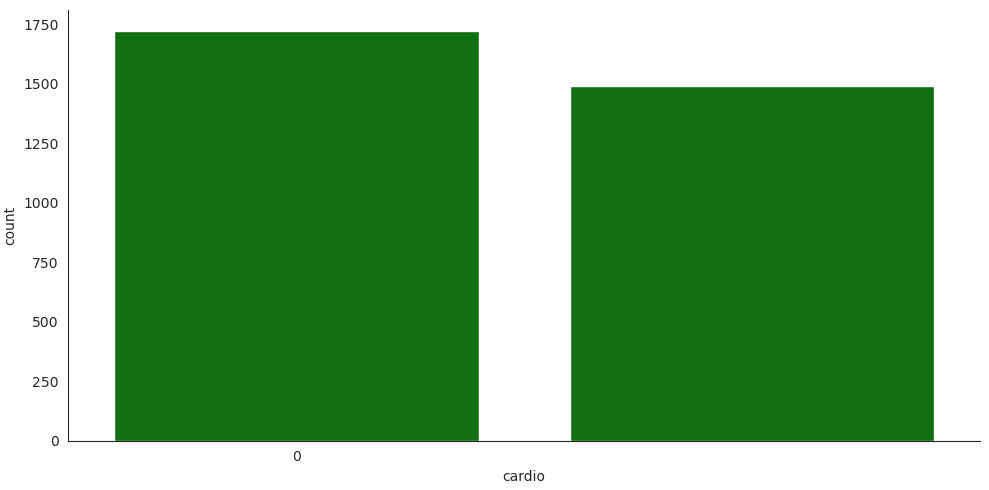

In [611]:
df_alco = df.loc[df["alco"] == 1]
with sns.axes_style('white'):
    g = sns.factorplot("cardio", data=df_alco, aspect=2,
                       kind="count", color='green')
    g.set_xticklabels(step=5)
    #alcohol consumption does not seem to be increase CVD

<AxesSubplot: ylabel='active'>

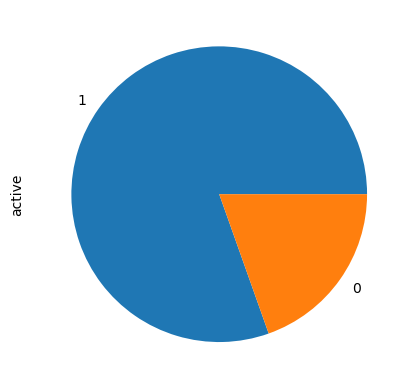

In [612]:
df["active"].value_counts().plot(kind='pie')
#most of the patients in the dataset are seen to be more physically active than inactive

/Users/tamikaramkissoon/opt/anaconda3/envs/kris_env/lib/python3.10/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/tamikaramkissoon/opt/anaconda3/envs/kris_env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


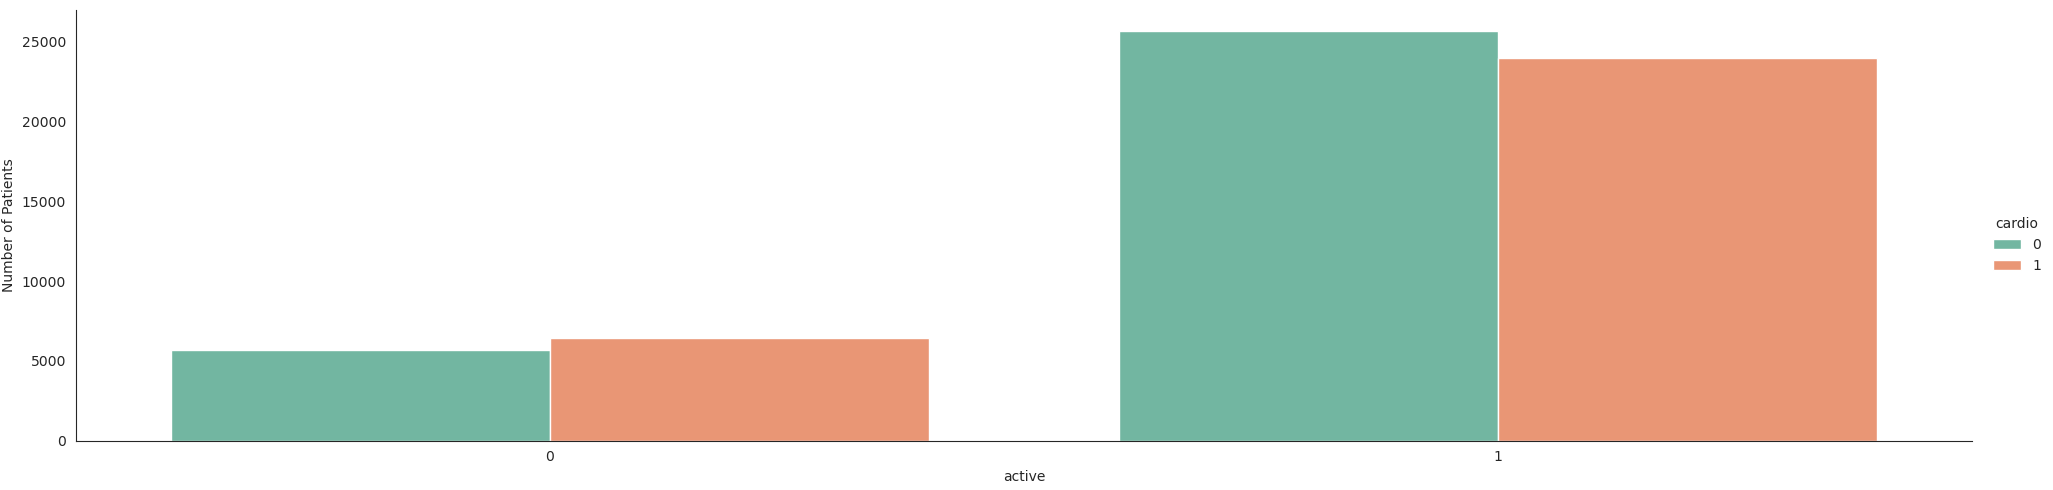

In [613]:
with sns.axes_style('white'):
    g = sns.factorplot("active", data=df, aspect=4.0, kind='count',
                       hue='cardio', palette="Set2")
    g.set_ylabels('Number of Patients')
    #The physically active patients are less at risk to CVD

<AxesSubplot: ylabel='smoke'>

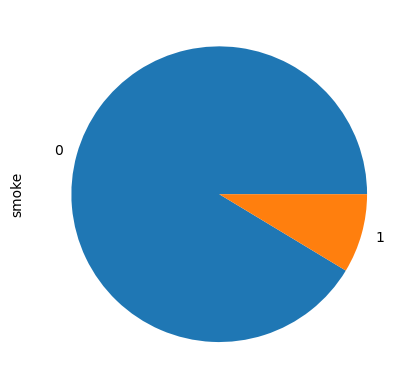

In [614]:
df["smoke"].value_counts().plot(kind='pie')
# There are more non-smokers in this dataset

/Users/tamikaramkissoon/opt/anaconda3/envs/kris_env/lib/python3.10/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/tamikaramkissoon/opt/anaconda3/envs/kris_env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


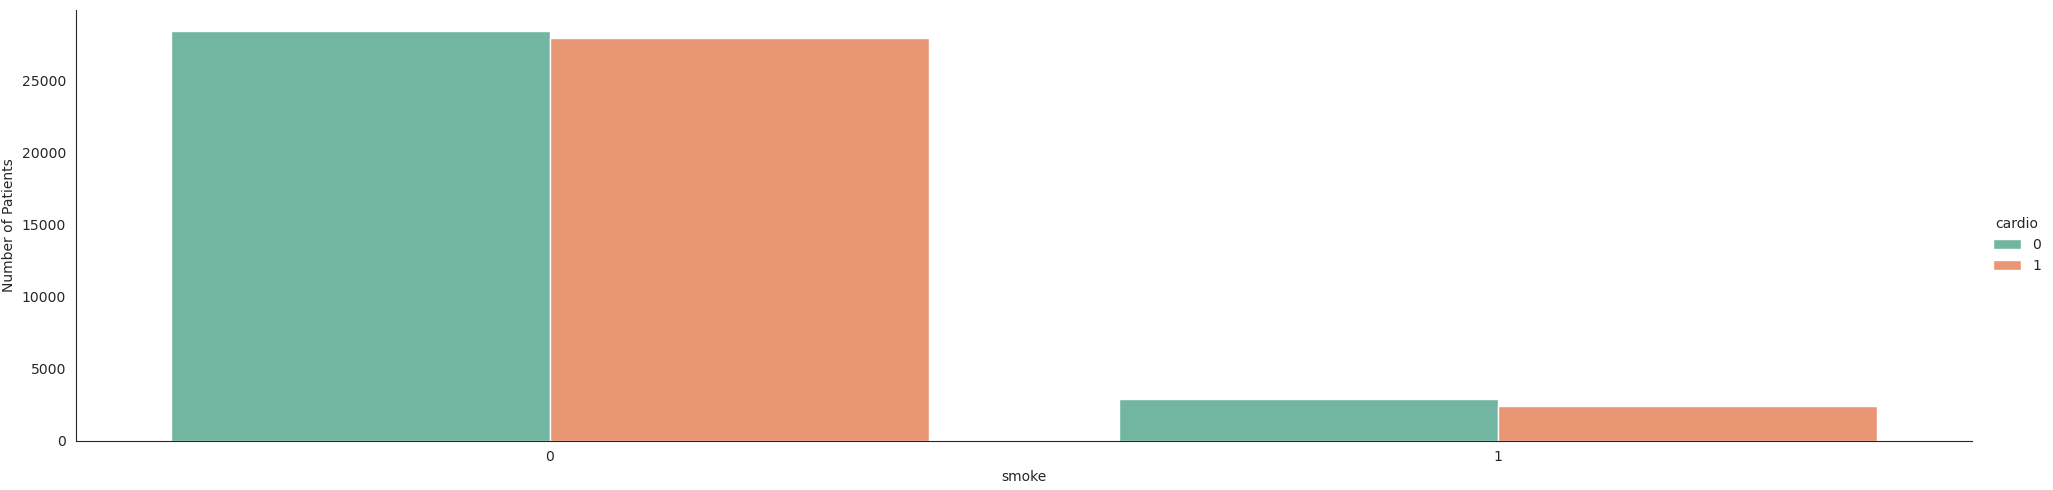

In [615]:
with sns.axes_style('white'):
    g = sns.factorplot("smoke", data=df, aspect=4.0, kind='count',
                       hue='cardio', palette="Set2")
    g.set_ylabels('Number of Patients')
    #Patients who are non smokers are seen to be more prone to CVD

## Bivariate

In [616]:
df.groupby('gender')['height'].mean()
#Since men tend to be taller tham women, 2 will be assumed to be men.
# 1 : women , 2: men

gender
1    161.576252
2    169.732609
Name: height, dtype: float64

In [617]:
df['gender'].value_counts()

1    40222
2    21549
Name: gender, dtype: int64

In [618]:
df.groupby('gender')['gluc'].sum()
#women have higher glucose level on avg

gender
1    49496
2    25871
Name: gluc, dtype: int64

In [619]:
df.groupby('gender')['cholesterol'].sum()
#women have higher cholesterol on avg

gender
1    55406
2    28347
Name: cholesterol, dtype: int64

In [620]:
df.groupby('gender')['smoke'].sum()
#men are more smokers on avg

gender
1     689
2    4650
Name: smoke, dtype: int64

In [621]:
df.groupby('gender')['alco'].sum()
# men drink more alcohol than women on avg

gender
1     993
2    2220
Name: alco, dtype: int64

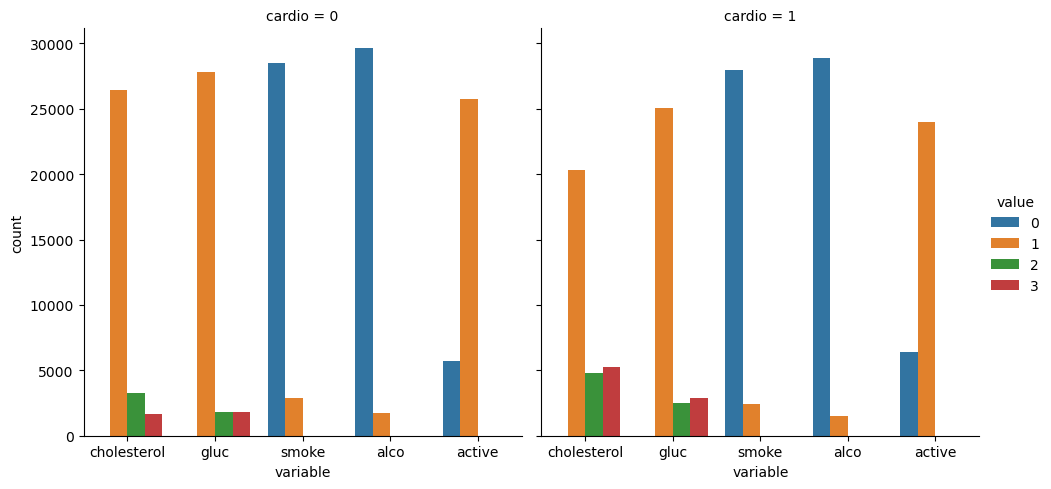

In [622]:
data1 = pd.melt(df, id_vars=['cardio'], value_vars=['cholesterol','gluc', 'smoke', 'alco', 'active'])
sns.catplot(x="variable", hue="value",col="cardio",data= data1,kind="count")
# this shows that patients who have high cholesterol and high glucose level are more prone to have CVD

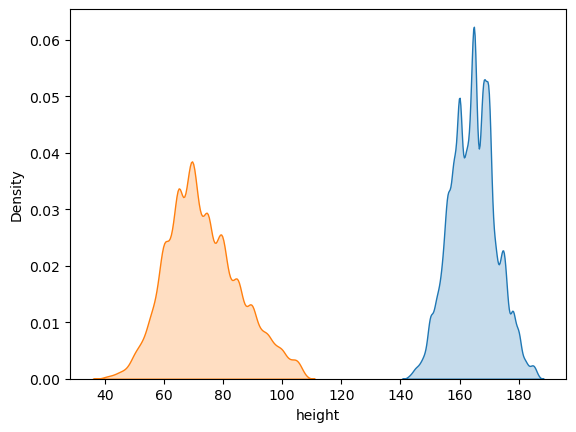

In [623]:
for col in ["height", "weight"]:
    sns.kdeplot(df[col], shade=True)

## Multivariate

In [624]:
#Calculate correlations
corr = df.corr()
#covariance matrix tell us how one feature varies to the other one 

/var/folders/lg/3khrfgwn2w920qd0wcmjxpph0000gn/T/ipykernel_35630/2884907696.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)
/var/folders/lg/3khrfgwn2w920qd0wcmjxpph0000gn/T/ipykernel_35630/2884907696.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  create = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot: >

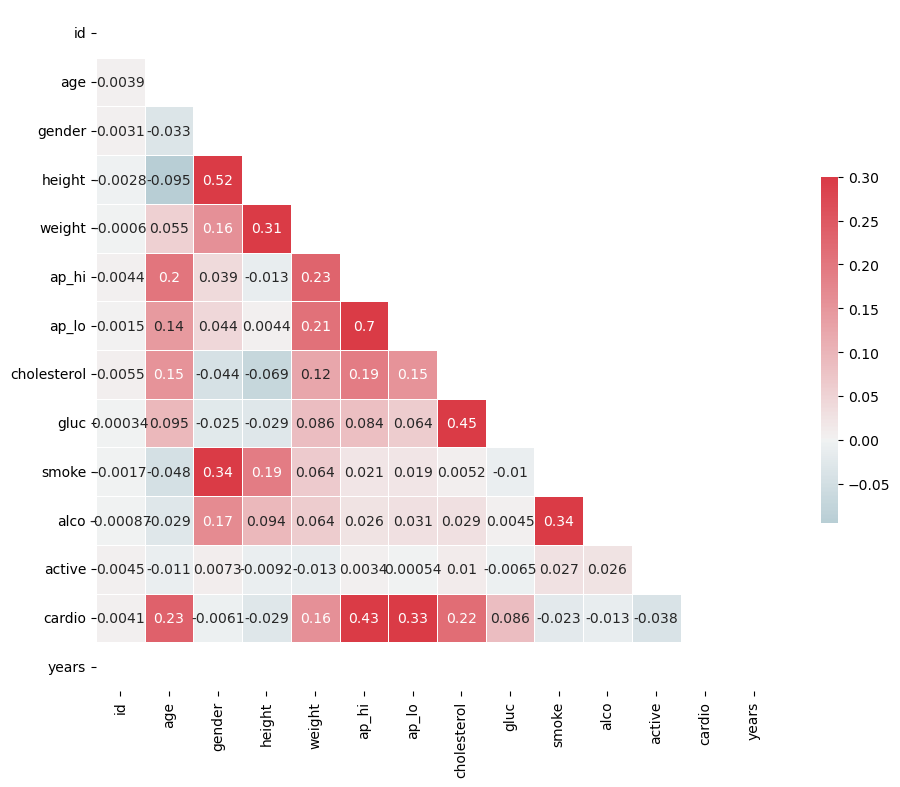

In [625]:
# create a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)
create = np.zeros_like(corr, dtype=np.bool)
create[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot: >

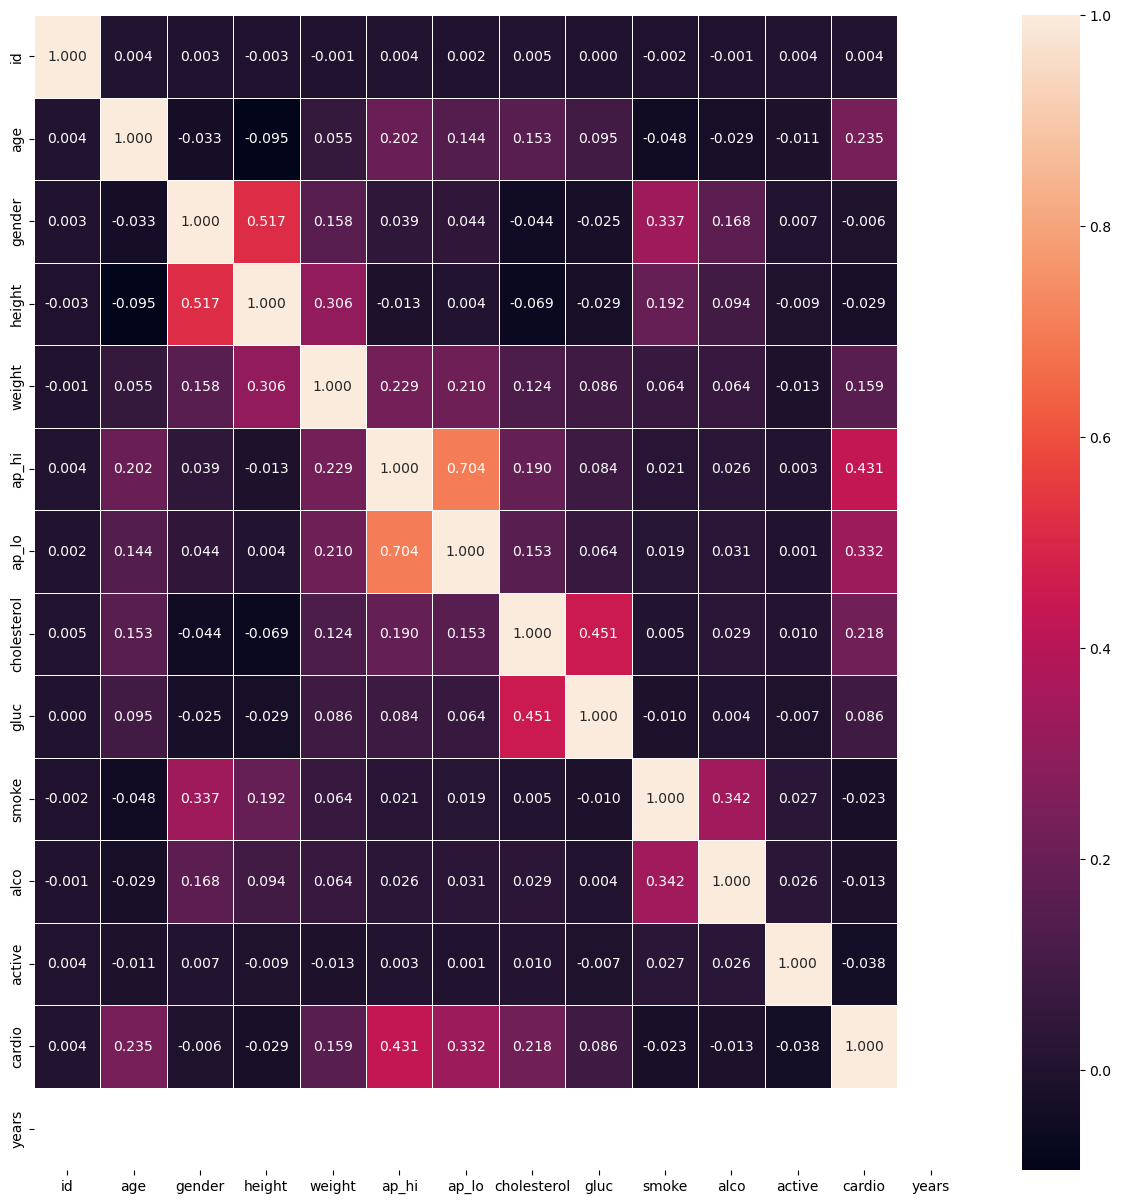

In [626]:
corr = df.corr()
f, ax = plt.subplots(figsize = (15,15))
sns.heatmap(corr, annot=True, fmt=".3f", linewidths=0.5, ax=ax)

From the heatmap, the weight, age and cholestrol seem to have the highest correlation with respect to our target variable(cardio). There is a correlation between weight, age and cholesterol?. Being overweight or obese tends to increase bad cholesterol and lower good cholesterol. Aging also causes cholesterol to increase. 

Cholesterol and glucose have a high correlation, whcih makes sense due to studies which show that elevated blood glucose levels (any type of diabetes) poses a risk of higher cholesterol, manifesting as diabetic dyslipidemia.

Calculating the BMI

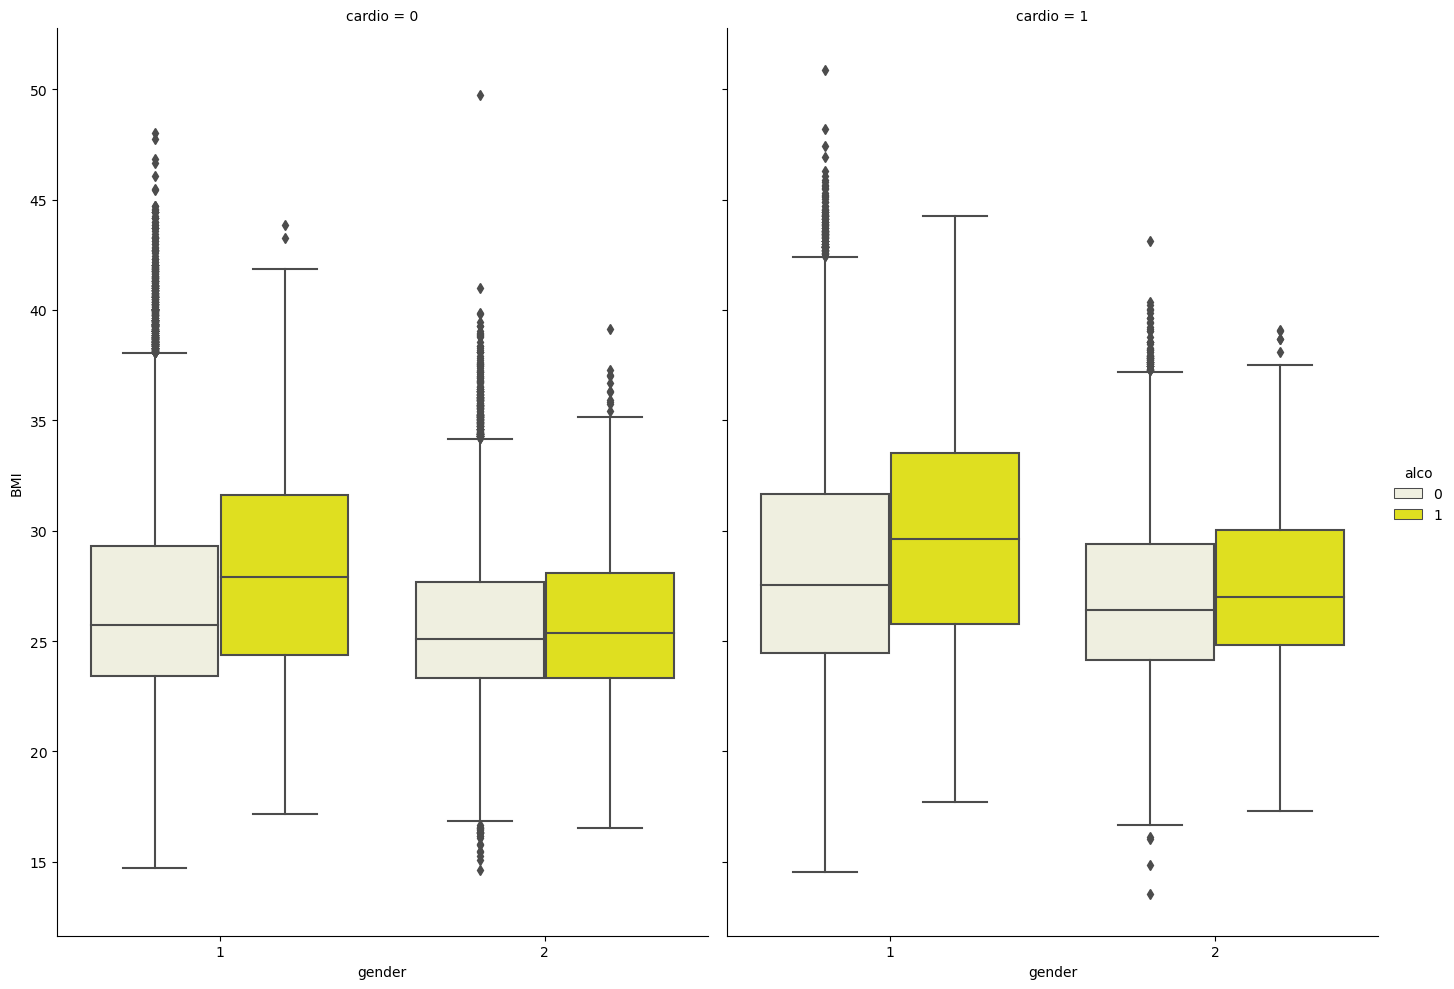

In [627]:
df['BMI'] = df['weight']/((df['height']/100)**2)
sns.catplot(x="gender", y="BMI", hue="alco", col="cardio", data=df, color = "yellow",kind="box", height=10, aspect=.7)

<AxesSubplot: ylabel='BMI_State'>

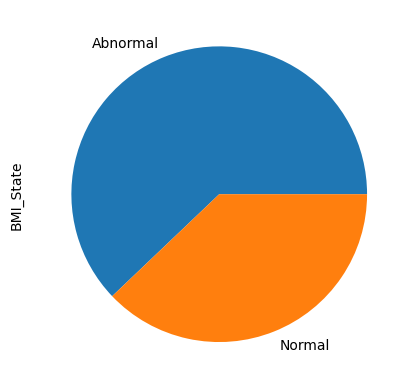

In [628]:
# determining normal & abnormal BMI
def bmi(bmi_num):
  if 18.5 <= bmi_num <= 25:
    return "Normal"
  else:
    return "Abnormal"

df["BMI_State"] = df["BMI"].apply(lambda x: bmi(x))
df["BMI_State"].value_counts().plot(kind='pie')

#There was a higher rate of abnormal BMI than normal

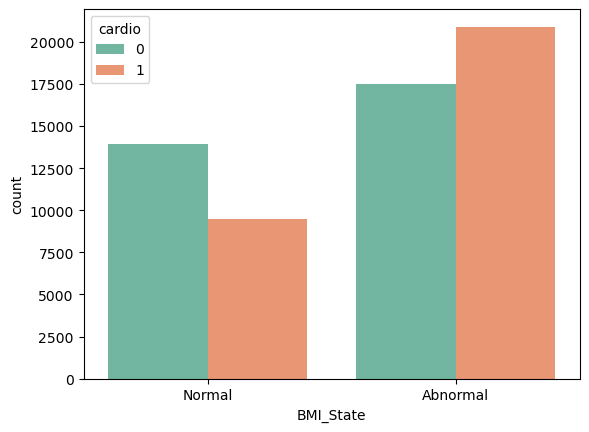

In [629]:
sns.countplot(x='BMI_State', hue='cardio', data = df, palette="Set2");
##patients with abnormal BMI are more prone to CVD

## Feature

The features that are prominently shown to lead to CSV are non-smokers, those with high cholesterol, high glucose level and older patients. 

#### Binary Classification: Random Forest

Split the dataset into a 70-20-10 ratio for training, testing, and prediction sets, respectively.

In [630]:
#dropping irrelevant features
df.head()
df = df.drop('BMI_State', axis=1)
df = df.drop('years', axis=1)

In [631]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', axis=1), df['cardio'], test_size=0.3, random_state=42)


In [632]:
# Split the testing data further into testing and prediction sets
X_test, X_pred, y_test, y_pred = train_test_split(X_test, y_test, test_size=0.1, random_state=42)

Define hyperparameter to search over to increase test scores:

In [633]:
# Define the hyperparameters to search over:
param_grid = {'max_depth': [2, 4, 6, 8, 10],
              'min_samples_split': [2, 4, 6, 8, 10]}


Train the model using the training data set; X_train and Y_train

In [634]:
# Create a random forest classifier with 100 trees
rfc = RandomForestClassifier(n_estimators=1, random_state=42)

# Train the model on the training data
grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=1, random_state=42),
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                         'min_samples_split': [2, 4, 6, 8, 10]})

In [635]:
# Get the best decision tree from the grid search:
decision_tree = grid_search.best_estimator_.estimators_[0]

Evaluate the model's performance using the testing dataset, X_test and Y_test

In [636]:
# Evaluate the decision tree's performance on the testing set:
accuracy = decision_tree.score(X_test, y_test)
print(f"Accuracy on testing data: {accuracy}")

Accuracy on testing data: 0.7141144022064996


/Users/tamikaramkissoon/opt/anaconda3/envs/kris_env/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [637]:
# Use the decision tree to make predictions on the prediction set:
y_pred = decision_tree.predict(X_pred)
print(y_pred)

[1. 0. 0. ... 1. 0. 1.]


/Users/tamikaramkissoon/opt/anaconda3/envs/kris_env/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [638]:
# Evaluate the model's performance on the testing set
y_pred = grid_search.predict(X_test)
y_true = y_test
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1 score:', f1)


Accuracy: 0.7141144022064996
Precision: 0.7422973164844526
Recall: 0.6390416819459723
F1 score: 0.6868102995270625


Confusion matrix: Measure of true positives and true negatives from the prediction

In [639]:
# Get the confusion matrix for the prediction:
cm = confusion_matrix(y_pred, y_true)
# Calculate the true positives and true negatives from the confusion matrix:
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"False Negative: {fn}")

True Negatives: 6682
True Positives: 5228
False Positives: 2953
False Negative: 1815


In [640]:
# Use the trained model to predict the likelihood of CVD for new individuals in the prediction set
y_predict_proba = grid_search.predict_proba(X_pred)[:, 1]
print(y_predict_proba *100)


[85.58707124 28.69574446 28.69574446 ... 85.58707124 14.44342226
 56.66666667]


#### Binary Classification: CART

Split the data and restart the process using a CART Model 

In [641]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', axis=1), df['cardio'], test_size=0.3, random_state=42)

Create a decision tree model using CART algorithm

In [642]:
dtc = DecisionTreeClassifier(random_state=42)

Train the model using the training dataset

In [643]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Evaluate the model using the testing dataset

In [644]:
y_pred = dtc.predict(X_test)

Use the model to predict the target for new individuals 

In [645]:
df_new = df.sample(frac=0.1, random_state=42)
X_new = df_new.drop('cardio', axis=1)
y_new_true = df_new['cardio']
y_new_pred = dtc.predict(X_new)

Evaluate the model using the training dataset

In [646]:
y_train_pred = dtc.predict(X_train)

print('Confusion matrix for training dataset:')
cm=confusion_matrix(y_new_pred, y_new_true)
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"False Negative: {fn}")

print('Accuracy score for training dataset:', accuracy_score(y_new_pred, y_new_true))
print('Precision score for training dataset:', precision_score(y_new_pred, y_new_true))
print('Recall score for training dataset:', recall_score(y_new_pred, y_new_true))
print('F1 score for training dataset:', f1_score(y_new_pred, y_new_true))


Confusion matrix for training dataset:
True Negatives: 2024
True Positives: 1894
False Positives: 1128
False Negative: 1131
Accuracy score for training dataset: 0.6342884895580378
Precision score for training dataset: 0.6267372600926538
Recall score for training dataset: 0.6261157024793389
F1 score for training dataset: 0.6264263271043493


Tune the model to improve performance

In [647]:
parameters = {'max_depth': range(1, 11),
              'min_samples_leaf': range(1, 6)}

grid_search = GridSearchCV(estimator=dtc, param_grid=parameters, cv=5, n_jobs=-1)

In [648]:
grid_search.fit(X_train, y_train)

print('Best parameters:', grid_search.best_params_)

Best parameters: {'max_depth': 5, 'min_samples_leaf': 1}


In [649]:
dtc_tuned = grid_search.best_estimator_

Evaluate the tuned model using the testing dataset

In [650]:
y_tuned_pred = dtc_tuned.predict(X_test)

print('Confusion matrix for tuned model and testing dataset:')
cm=confusion_matrix(y_test, y_tuned_pred)
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"False Negative: {fn}")

print('Accuracy score for tuned model and testing dataset:', accuracy_score(y_test, y_tuned_pred))
print('Precision score for tuned model and testing dataset:', precision_score(y_test, y_tuned_pred))
print('Recall score for tuned model and testing dataset:', recall_score(y_test, y_tuned_pred))
print('F1 score for tuned model and testing dataset:', f1_score(y_test, y_tuned_pred))

Confusion matrix for tuned model and testing dataset:
True Negatives: 7411
True Positives: 6018
False Positives: 2034
False Negative: 3069
Accuracy score for tuned model and testing dataset: 0.7246384631987913
Precision score for tuned model and testing dataset: 0.7473919523099851
Recall score for tuned model and testing dataset: 0.6622647738527567
F1 score for tuned model and testing dataset: 0.7022580080518116
